71946575
61343553


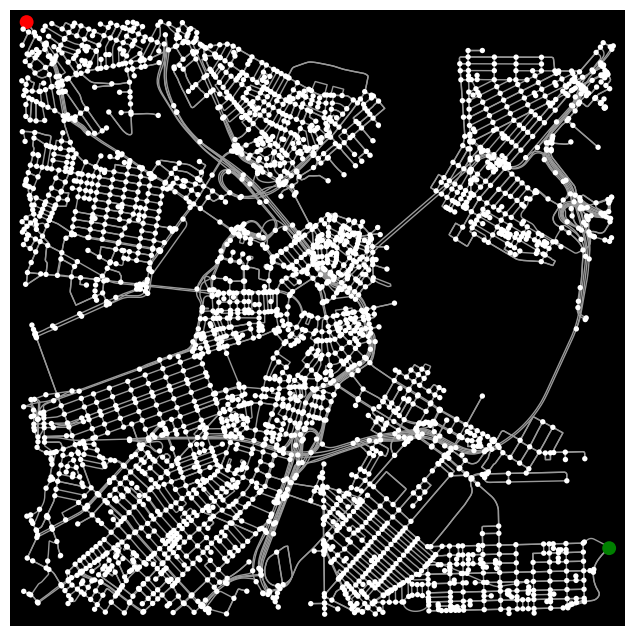

In [1]:
import json
import copy
import math
import heapq
from dataclasses import dataclass
from typing import TypeAlias

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib

import osmnx as ox
from IPython.display import HTML

ox.settings.use_cache = True
ox.settings.cache_folder = './cache' 

address = "Institute of Contemporary Art, 25 Harbor Shore Dr, Boston, MA 02210"
place = "Boston, MA"

try:
    G = ox.graph_from_address(place, dist = 3000, network_type="drive")
    start_node = ox.distance.nearest_nodes(G, X=-71.2299, Y=42.4479)
    print(start_node)
    end_node = ox.distance.nearest_nodes(G, X=-71.00328, Y=42.343929)
    print(end_node)
    node_colors = ['red' if node == start_node else 'green' if node == end_node else 'white' for node in G.nodes()]
    node_sizes = [100 if node == start_node or node == end_node  else 15 for node in G.nodes()]

    adj_dict = {
        int(u): {int(v): round(float(d[0]['length']), 2) for v, d in nbrs.items()}
        for u, nbrs in G.adj.items()
    }

    fig, ax = ox.plot_graph(
        G, 
        node_color=node_colors, 
        node_size=node_sizes, 
        node_zorder=3, 
        bgcolor='black'
    )
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [2]:
Vertex: TypeAlias = int
Weight: TypeAlias = int | float

@dataclass
class Edge:
    vertex: Vertex
    weight: Weight

Neighbors: TypeAlias = dict[Edge]

# Graph Library

def graph_get_neighbors(vertex: Vertex, adj_dict: dict[Vertex, Neighbors]) -> Neighbors:
    return adj_dict[int(vertex)].copy()

def graph_hasmore_neighbors(nbors: Neighbors) -> bool:
    return len(nbors) > 0

def graph_next_neighbor_edge(nbors: Neighbors) -> Edge:
    key, weight = next(iter(nbors.items()))
    nbors.pop(key)
    return Edge(vertex=key, weight=weight)

def graph_next_neighbor_key(nbors: Neighbors) -> Vertex:
    key, weight = next(iter(nbors.items()))
    nbors.pop(key)
    return key

In [3]:
# DFS implementation
def dfs(start: Vertex, end: Vertex) -> bool:
    visited: set[Vertex] = set()

    def dfs_helper(current: Vertex, target: Vertex, visited: set[Vertex]) -> bool:
        if current == target:
            return True
        
        visited.add(current)
        nbors = graph_get_neighbors(current)
        
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)

            if neighbor not in visited:
                if dfs_helper(neighbor, target, visited):
                    return True
        return False
    
    return dfs_helper(start, end, visited)

Path found with 786 nodes.


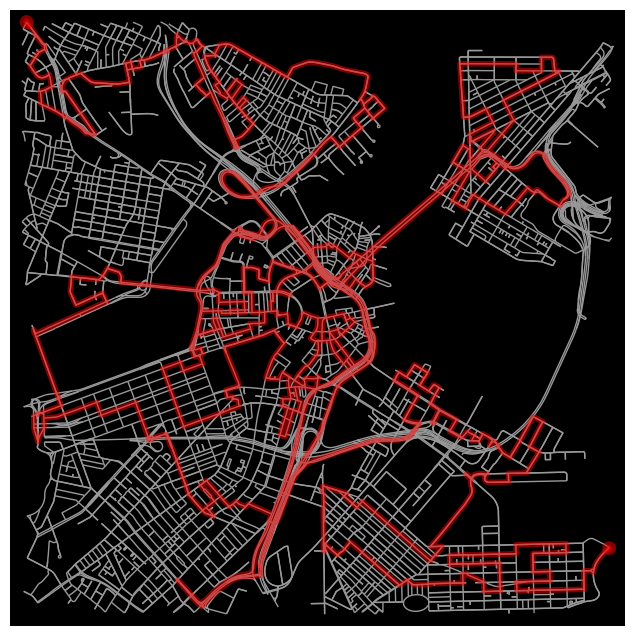

In [6]:
# DFS impementation - saves path and displays it
def dfs_with_path(start, end):
    visited = set()
    path = []
    
    def dfs_helper(current, target, visited, path):
        visited.add(current)
        path.append(int(current))
        
        if int(current) == int(target):
            return True
        
        nbors = graph_get_neighbors(int(current), adj_dict)
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)
            if neighbor not in visited:
                if dfs_helper(neighbor, target, visited, path):
                    return True
                
        path.pop()
        return False

    success = dfs_helper(str(start), str(end), visited, path)
    return path if success else None

def visualize_dfs_route(G, path):
    if not path:
        print("No path found between the specified nodes.")
        return

    print(f"Path found with {len(path)} nodes.")
    
    fig, ax = ox.plot_graph_route(
        G, 
        path, 
        route_color="red", 
        route_linewidth=4, 
        node_size=0, 
        bgcolor='black'
    )
    plt.show()

path_nodes = dfs_with_path(start_node, end_node)
visualize_dfs_route(G, path_nodes)

KeyboardInterrupt: 

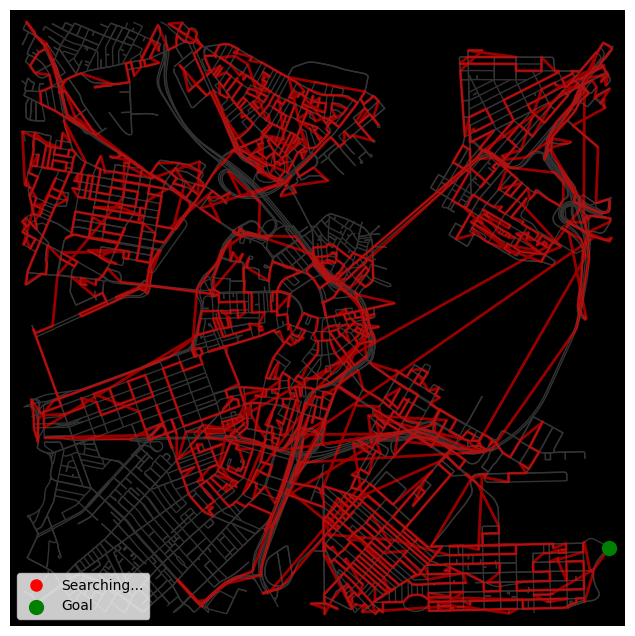

In [7]:
# DFS animation

def animate_dfs(G, start_node, end_node):
    visited = set()
    visit_order = []
    matplotlib.rcParams['animation.embed_limit'] = 1000.0
    def dfs_recorder(current, target):
        if current in visited:
            return False
        
        visited.add(current)
        visit_order.append(current)
        
        if int(current) == int(target):
            return True
        
        nbors = graph_get_neighbors(int(current), adj_dict)
        while graph_hasmore_neighbors(nbors):
            neighbor = graph_next_neighbor_key(nbors)
            if neighbor not in visited:
                if dfs_recorder(neighbor, target):
                    return True
        return False

    dfs_recorder(str(start_node), str(end_node))

    fig, ax = ox.plot_graph(G, node_size=0, edge_color='#333333', bgcolor='black', show=False, close=False)
    
    search_dot, = ax.plot([], [], 'ro', markersize=8, label='Searching...')
    path_line, = ax.plot([], [], color='red', linewidth=2, alpha=0.6)
    target_node = G.nodes[int(end_node)]
    ax.scatter(target_node['x'], target_node['y'], c='green', s=100, label='Goal', zorder=5)

    x_coords = [G.nodes[int(node)]['x'] for node in visit_order]
    y_coords = [G.nodes[int(node)]['y'] for node in visit_order]

    def init():
        search_dot.set_data([], [])
        path_line.set_data([], [])
        return search_dot, path_line

    def update(frame):
        search_dot.set_data([x_coords[frame]], [y_coords[frame]])
        path_line.set_data(x_coords[:frame+1], y_coords[:frame+1])
        return search_dot, path_line
    ani = FuncAnimation(fig, update, frames=len(visit_order), 
                        init_func=init, blit=True, interval=50)
    
    plt.legend()
    return ani

ani = animate_dfs(G, start_node, end_node)
ani.save('dfs_animation.gif', writer='pillow', fps=20)
# HTML(ani.to_jshtml())

In [8]:
# Priority queue Library
@dataclass
class D_Vertex:
    vertex: Vertex
    distance: float

def enq(pq: list, d: D_Vertex):
    heapq.heappush(pq, (d.distance, d.vertex))

def deq(pq: list) -> D_Vertex:
    if not pq:
        print("Queue empty.")
        exit()

    dist, v_id = heapq.heappop(pq)
    return D_Vertex(vertex=v_id, distance=dist)

def is_empty(pq: list) -> bool:
    return len(pq) == 0

Path found with 78 nodes.


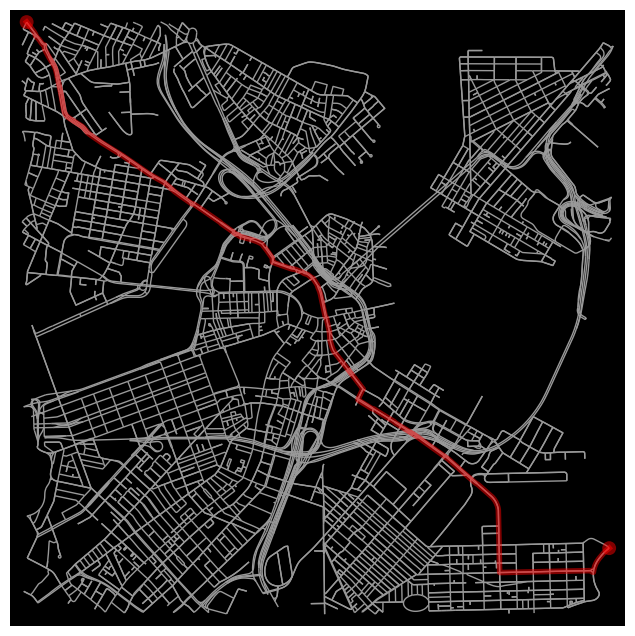

In [9]:
# dijkstra's
parents = {}
dist = {}
for node in G.nodes():
    dist[int(node)] = math.inf

dist[start_node] = 0
to_visit: list[D_Vertex] = []
enq(to_visit, D_Vertex(start_node, 0))

while not is_empty(to_visit):
    d_vertex = deq(to_visit)

    if d_vertex.distance > dist[d_vertex.vertex]:
        continue

    nbors = graph_get_neighbors(d_vertex.vertex, adj_dict)
    while graph_hasmore_neighbors(nbors):
        edge = graph_next_neighbor_edge(nbors)
        candidate_weight = d_vertex.distance + edge.weight
        
        v_id = int(edge.vertex)
        if dist[v_id] > candidate_weight:
            dist[v_id] = candidate_weight
            parents[v_id] = d_vertex.vertex
            enq(to_visit, D_Vertex(vertex=v_id, distance=candidate_weight))

if end_node not in parents:
    print("No path exists!")
    path_nodes = []
else:
    path_nodes = []
    node = end_node
    while node is not None:
        path_nodes.append(node)
        node = parents.get(node)
    path_nodes.reverse()

visualize_dfs_route(G, path_nodes)

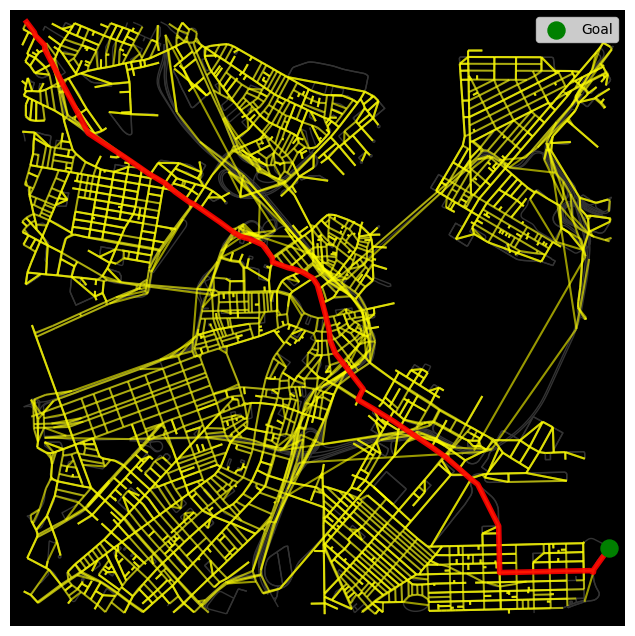

In [10]:
from matplotlib.collections import LineCollection

def animate_dijkstra_edges(G, start_node, end_node):
    start_node = int(start_node)
    end_node = int(end_node)
    
    parents = {}
    found_end = False
    dist = {int(node): math.inf for node in G.nodes()}
    dist[start_node] = 0
    
    to_visit = []
    enq(to_visit, D_Vertex(start_node, 0))
    
    explored_edges_coords = []
    
    while not is_empty(to_visit) and not found_end:
        d_vertex = deq(to_visit)
        u_id = d_vertex.vertex
        
        if d_vertex.distance > dist[u_id]:
            continue
            
        if u_id == end_node:
            break
            
        nbors = graph_get_neighbors(u_id, adj_dict)

        while graph_hasmore_neighbors(nbors):
            edge = graph_next_neighbor_edge(nbors)
            v_id = int(edge.vertex)

            u_node = G.nodes[u_id]
            v_node = G.nodes[v_id]
            explored_edges_coords.append(((u_node['x'], u_node['y']), (v_node['x'], v_node['y'])))
            
            candidate_weight = d_vertex.distance + edge.weight
            if dist[v_id] > candidate_weight:
                dist[v_id] = candidate_weight
                parents[v_id] = u_id
                enq(to_visit, D_Vertex(vertex=v_id, distance=candidate_weight))
                if v_id == end_node: 
                    found_end = True
        
    fig, ax = ox.plot_graph(G, node_size=0, edge_color='#333333', 
                            bgcolor='black', show=False, close=False)
    
    edge_drawing = LineCollection([], colors='yellow', linewidths=1.5, alpha=0.6)
    ax.add_collection(edge_drawing)
    
    final_path_line, = ax.plot([], [], color='red', linewidth=4, alpha=0.9, zorder=10)

    target_node = G.nodes[end_node]
    ax.scatter(target_node['x'], target_node['y'], c='green', s=150, label='Goal', zorder=11)

    def init():
        edge_drawing.set_segments([])
        final_path_line.set_data([], [])
        return edge_drawing, final_path_line

    def update(frame):
        edge_drawing.set_segments(explored_edges_coords[:frame])
        
        if frame == len(explored_edges_coords) - 1 and end_node in parents:
            path = []
            curr = end_node
            while curr is not None:
                path.append(curr)
                curr = parents.get(curr)
            
            px = [G.nodes[n]['x'] for n in path]
            py = [G.nodes[n]['y'] for n in path]
            final_path_line.set_data(px, py)
            
        return edge_drawing, final_path_line
    ani = FuncAnimation(fig, update, frames=len(explored_edges_coords), 
                        init_func=init, blit=True, interval=200)
    
    plt.legend()
    return ani

ani_dijkstra = animate_dijkstra_edges(G, start_node, end_node)
ani_dijkstra.save('dijkstra_animation.gif', writer='pillow', fps=20)
# HTML(ani_dijkstra.to_jshtml())

In [11]:
ani_dijkstra.save('dijkstra_animation.gif', writer='pillow', fps=20)

In [17]:
# Library

@dataclass
class A_Vertex:
    vertex: int
    distance: float  
    priority: float  

def A_enq(pq: list, d: A_Vertex):
    heapq.heappush(pq, (d.priority, d.distance, d.vertex))

def A_deq(pq: list) -> A_Vertex:
    prio, dist, v_id = heapq.heappop(pq)
    return A_Vertex(vertex=v_id, distance=dist, priority=prio)

def A_get_h(v1, v2): # claculate euclidean distance
    n1 = G.nodes[v1]
    n2 = G.nodes[v2]
    return ox.distance.euclidean(n1['y'], n1['x'], n2['y'], n2['x'])*150000

def A_is_empty(pq: list) -> bool:
    return len(pq) == 0

# A*

parents = {}
dist = {int(node): math.inf for node in G.nodes()}

dist[start_node] = 0
to_visit = []

h_start = A_get_h(start_node, end_node)
A_enq(to_visit, A_Vertex(start_node, 0, h_start))

while not A_is_empty(to_visit):
    d_vertex = A_deq(to_visit)

    if d_vertex.distance > dist[d_vertex.vertex]:
        continue
    
    if d_vertex.vertex == end_node:
        break

    nbors = graph_get_neighbors(d_vertex.vertex, adj_dict)
    while graph_hasmore_neighbors(nbors):
        edge = graph_next_neighbor_edge(nbors)
        v_id = int(edge.vertex)
        
        g_score = d_vertex.distance + edge.weight
        
        if dist[v_id] > g_score:
            dist[v_id] = g_score
            parents[v_id] = d_vertex.vertex
            
            # f = g + h
            f_score = g_score + A_get_h(v_id, end_node) # calculate score using dijkstras weight + euclidean distance
            A_enq(to_visit, A_Vertex(vertex=v_id, distance=g_score, priority=f_score)) # pass new culmaltive score

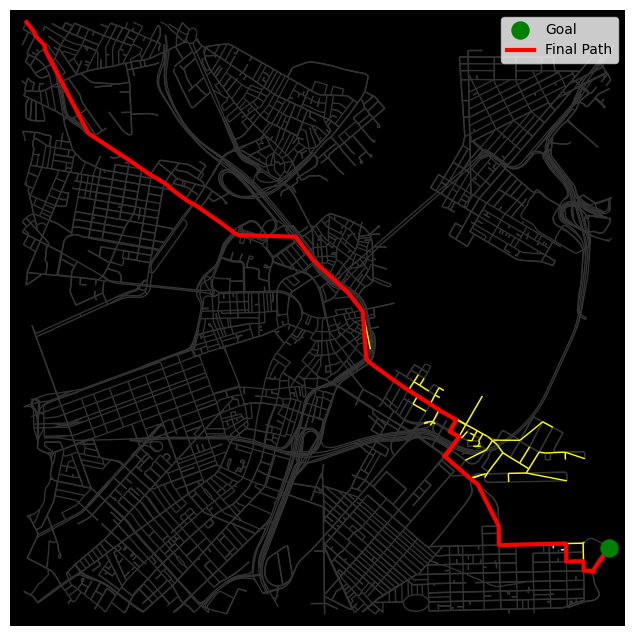

In [18]:
import matplotlib.collections as mc

def animate_astar_edges(G, start_node, end_node, adj_dict):
    to_visit = []
    heapq.heappush(to_visit, (A_get_h(start_node, end_node), start_node, 0.0, None))
    
    dist = {node: float('inf') for node in G.nodes()}
    dist[start_node] = 0.0
    
    explored_edges_coords = [] 
    parents = {}
    closed_list = set()

    while to_visit:
        priority, current, current_dist, parent = heapq.heappop(to_visit)
        
        if current in closed_list:
            continue
            
        closed_list.add(current)
        
        if parent is not None:
            u_data = G.nodes[parent]
            v_data = G.nodes[current]
            explored_edges_coords.append([(u_data['x'], u_data['y']), (v_data['x'], v_data['y'])])

        if current == end_node:
            break

        nbors = graph_get_neighbors(current, adj_dict)
        while graph_hasmore_neighbors(nbors):
            edge = graph_next_neighbor_edge(nbors)
            v_id = edge.vertex
            g_score = current_dist + edge.weight
            
            if g_score < dist[v_id]:
                dist[v_id] = g_score
                parents[v_id] = current
                f_score = g_score + A_get_h(v_id, end_node)
                heapq.heappush(to_visit, (f_score, v_id, g_score, current))

    fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#333333', bgcolor='black', node_size=0)
    
    edge_drawing = mc.LineCollection([], colors='yellow', linewidths=1, zorder=3)
    ax.add_collection(edge_drawing)
    target_node = G.nodes[end_node]
    ax.scatter(target_node['x'], target_node['y'], c='green', s=150, label='Goal', zorder=11)
    final_path_line, = ax.plot([], [], c='red', linewidth=3, zorder=5, label='Final Path')

    def init():
        edge_drawing.set_segments([])
        final_path_line.set_data([], [])
        return edge_drawing, final_path_line

    def update(frame):
        edge_drawing.set_segments(explored_edges_coords[:frame])
        
        if frame == len(explored_edges_coords) - 1:
            path = []
            curr = end_node
            while curr is not None:
                path.append(curr)
                curr = parents.get(curr)
            
            px = [G.nodes[n]['x'] for n in path]
            py = [G.nodes[n]['y'] for n in path]
            final_path_line.set_data(px, py)
            
        return edge_drawing, final_path_line

    ani = FuncAnimation(fig, update, frames=len(explored_edges_coords), 
                        init_func=init, blit=True, interval=50)
    
    plt.legend(loc='upper right')
    return ani

ani = animate_astar_edges(G, start_node, end_node, adj_dict)
ani.save('astar_animation.gif', writer='pillow', fps=20)
# HTML(ani.to_jshtml())